# Sistema de Recomendação de Filmes com Filtragem Colaborativa (KNN)


O objetivo deste projeto é desenvolver um sistema de recomendação de filmes baseado no método de filtragem colaborativa (User-Based).
O dataset utilizado é o MovieLens (ml-latest-small), contendo avaliações, tags e informações de filmes.

In [ ]:
# - filtragem (>=30 avaliações)
# - normalização por usuário (centralizar)
# - similaridade cosseno
# - ponderação por similaridade (weights = 1 - dist)
# - validação StratifiedShuffleSplit
# - varredura de K
# - RMSE + Precision@K, Recall@K, NDCG (top-N)

import numpy as np
import pandas as pd
from math import sqrt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# ------------------------
# Configurações / parâmetros
# ------------------------
RANDOM_STATE = 42
MIN_USER_RATINGS = 30   # filtro: usuários com >= 30 avaliações
MIN_MOVIE_RATINGS = 30  # filtro: filmes com >= 30 avaliações
TEST_SIZE = 0.2
KS = [5, 10, 15, 20, 25, 30]   # varredura de K
TOP_N = 10                     # para métricas top-N
SAMPLE_TEST_SIZE = 500         # amostra para RMSE/Top-N rápida
USE_MOVIELENS_100K = False    # se True: espera o dataset clássico (u.data). Se False: usa ratings.csv

# ------------------------
# Leitura dos dados
# ------------------------
def load_ratings():
    if USE_MOVIELENS_100K:
        # formato clássico MovieLens 100k (u.data) -> userId, movieId, rating, timestamp (tab separated)
        df = pd.read_csv("u.data", sep='\t', names=['userId','movieId','rating','timestamp'], engine='python')
    else:
        # usa ratings.csv (ml-latest-small / ml-latest etc)
        df = pd.read_csv("ratings.csv")
    return df

def load_movies():
    try:
        return pd.read_csv("movies.csv")
    except FileNotFoundError:
        # fallback para 100k item metadata if present
        try:
            movies = pd.read_csv("u.item", sep='|', names=[
                'movieId','title','release_date','video_release','IMDb_URL',
                'unknown','Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama',
                'Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'
            ], engine='python', encoding='latin-1')
            return movies[['movieId','title']]
        except Exception:
            return pd.DataFrame(columns=['movieId','title'])

ratings = load_ratings()
movies = load_movies()

print(f"[INFO] ratings shape: {ratings.shape}")
print(f"[INFO] movies shape: {movies.shape}")

# convert timestamp if numeric (some datasets)
if 'timestamp' in ratings.columns and np.issubdtype(ratings['timestamp'].dtype, np.integer):
    ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')
elif 'timestamp' in ratings.columns:
    try:
        ratings['datetime'] = pd.to_datetime(ratings['timestamp'])
    except Exception:
        pass

# ------------------------
# Pre-processamento e filtros
# ------------------------
# 1) remover linhas com NaNs nas colunas essenciais
ratings = ratings.dropna(subset=['userId','movieId','rating']).copy()
ratings['userId'] = ratings['userId'].astype(int)
ratings['movieId'] = ratings['movieId'].astype(int)

# 2) filtrar usuários e filmes com mínimo de avaliações
user_counts = ratings['userId'].value_counts()
active_users = user_counts[user_counts >= MIN_USER_RATINGS].index
ratings_active_users = ratings[ratings['userId'].isin(active_users)]

movie_counts = ratings_active_users['movieId'].value_counts()
active_movies = movie_counts[movie_counts >= MIN_MOVIE_RATINGS].index
ratings_filtered = ratings_active_users[ratings_active_users['movieId'].isin(active_movies)].copy()

print(f"[INFO] after filtering: ratings_filtered shape: {ratings_filtered.shape}")
print(f"[INFO] unique users: {ratings_filtered['userId'].nunique()}, unique movies: {ratings_filtered['movieId'].nunique()}")

# 3) criar matriz usuário-item filtrada
user_item = ratings_filtered.pivot_table(index='userId', columns='movieId', values='rating')

# 4) salvar lista de ids (mantém ordem)
user_index = user_item.index.tolist()
movie_index = user_item.columns.tolist()

# ------------------------
# Normalização por usuário (centralizar)
# ------------------------
user_means = user_item.mean(axis=1)               # média por usuário
user_item_norm = user_item.sub(user_means, axis=0)  # centraliza
# manter NaNs (não preencher com 0) para cálculos de máscara
print("[INFO] Normalização por usuário aplicada (centralizado em média do usuário).")

# ------------------------
# Construir matriz preenchida para KNN (com NaN->0 para distância)
# ------------------------
# Para cálculo de distâncias no sklearn / NearestNeighbors, precisamos preencher NaNs.
# Preencher com 0 após normalização (isso representa 'não-avaliação' no espaço centralizado).
matrix_for_knn = user_item_norm.fillna(0).values

# índice para mapear userId -> row index
userId_to_row = {uid:i for i,uid in enumerate(user_index)}
row_to_userId = {i:uid for uid,i in userId_to_row.items()}

# ------------------------
# Funções principais: previsão ponderada e recomendação
# ------------------------
from sklearn.metrics.pairwise import cosine_distances

def predict_rating_weighted(user_id, movie_id, k=20, matrix=matrix_for_knn):
    """
    Predição ponderada por similaridade (1 - distância cosseno)
    Usa a matriz normalizada (centralizada), preenche NaN com 0 para distâncias.
    Retorna nota prevista na escala original (adiciona a média do usuário).
    """
    if user_id not in userId_to_row or movie_id not in movie_index:
        return np.nan

    u_row = userId_to_row[user_id]
    user_vec = matrix[u_row].reshape(1, -1)
    distances = cosine_distances(user_vec, matrix)[0]   # distância cosseno (0 = idênticos)
    # ordenar por distância
    nn_idx = np.argsort(distances)
    # excluir o próprio usuário na lista de vizinhos
    nn_idx = nn_idx[nn_idx != u_row]
    # pegar os K primeiros
    nn_k = nn_idx[:k]
    dists_k = distances[nn_k]

    # recuperar as notas normalizadas dos vizinhos para o item (pode ser NaN -> precisamos acessar user_item_norm)
    neighbor_user_ids = [row_to_userId[i] for i in nn_k]
    neighbor_ratings = user_item_norm.loc[neighbor_user_ids, movie_id]

    # máscara vizinhos que têm rating no item
    mask = ~neighbor_ratings.isna()
    if mask.sum() == 0:
        # sem vizinhos que avaliaram -> fallback para média do usuário (não normalizada)
        return user_means.loc[user_id]

    # pesos: 1 - distance (quanto menor a distância, maior o peso)
    weights = 1.0 - dists_k[mask.values]
    if weights.sum() == 0:
        return user_means.loc[user_id]
    weighted_sum = np.dot(neighbor_ratings[mask].values, weights)
    pred_norm = weighted_sum / weights.sum()
    # devolver na escala original
    return pred_norm + user_means.loc[user_id]

def recommend_knn_for_user(user_id, k=20, n_rec=10):
    """
    Recomenda top-n filmes para um usuário usando média ponderada dos K vizinhos.
    Retorna list of (movieId, score)
    """
    if user_id not in userId_to_row:
        return []

    # média ponderada por vizinhos para todos os filmes (vetorizado)
    u_row = userId_to_row[user_id]
    user_vec = matrix_for_knn[u_row].reshape(1, -1)
    distances = cosine_distances(user_vec, matrix_for_knn)[0]
    nn_idx = np.argsort(distances)
    nn_idx = nn_idx[nn_idx != u_row][:k]
    neighbor_user_ids = [row_to_userId[i] for i in nn_idx]
    dists_k = distances[nn_idx]
    weights = 1.0 - dists_k
    # criar DataFrame com neighbors x movies (usando user_item_norm)
    neighbors_norm = user_item_norm.loc[neighbor_user_ids]
    # para cada movie, considerar apenas vizinhos com rating
    scores = {}
    for movie in movie_index:
        neigh_ratings = neighbors_norm[movie]
        mask = ~neigh_ratings.isna()
        if mask.sum() == 0:
            continue
        w = weights[mask.values]
        if w.sum() == 0:
            continue
        score_norm = np.dot(neigh_ratings[mask].values, w) / w.sum()
        # trazer para escala original adicionando média do usuário alvo
        scores[movie] = score_norm + user_means.loc[user_id]
    # remover filmes já assistidos pelo usuário
    user_seen = user_item.loc[user_id].dropna().index.tolist() if user_id in user_item.index else []
    recs = sorted([(m,s) for m,s in scores.items() if m not in user_seen], key=lambda x: x[1], reverse=True)
    return recs[:n_rec]

# ------------------------
# Validação: StratifiedShuffleSplit por atividade do usuário
# ------------------------
# Criar uma coluna auxiliar de "atividade do usuário" para estratificação:
# aqui usamos quantis da contagem de ratings por usuário (antes do filtro)
user_activity = ratings.groupby('userId').size()
# para estratificar na divisão global (usando ratings original), mapeamos userId para bins
n_bins = 10
user_bins = pd.qcut(user_activity.rank(method='first'), q=n_bins, labels=False, duplicates='drop')
user_bin_map = user_bins.to_dict()  # map userId -> bin

# adicionar coluna user_bin ao ratings original (tolerância: só para usuários presentes)
ratings['user_bin'] = ratings['userId'].map(user_bin_map).fillna(0).astype(int)

splitter = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_idx, test_idx = next(splitter.split(ratings, ratings['user_bin']))

train_df = ratings.iloc[train_idx].copy()
test_df = ratings.iloc[test_idx].copy()
print(f"[INFO] train shape: {train_df.shape}, test shape: {test_df.shape}")

# Para avaliação prática, limitamos o teste a SAMPLE_TEST_SIZE avaliações representativas
if SAMPLE_TEST_SIZE is not None and SAMPLE_TEST_SIZE < len(test_df):
    sample_test = test_df.sample(SAMPLE_TEST_SIZE, random_state=RANDOM_STATE)
else:
    sample_test = test_df

# ------------------------
# Funções de métricas top-N: Precision@N, Recall@N, NDCG@N
# ------------------------
def precision_at_k(recommended, relevant_set, k):
    if len(recommended) == 0:
        return 0.0
    recommended_k = [r for r,_ in recommended[:k]]
    hits = sum([1 for m in recommended_k if m in relevant_set])
    return hits / k

def recall_at_k(recommended, relevant_set, k):
    if len(relevant_set) == 0:
        return 0.0
    recommended_k = [r for r,_ in recommended[:k]]
    hits = sum([1 for m in recommended_k if m in relevant_set])
    return hits / len(relevant_set)

def dcg(recommended, relevant_set, k):
    dcg_val = 0.0
    for i,(m,score) in enumerate(recommended[:k]):
        rel = 1.0 if m in relevant_set else 0.0
        denom = np.log2(i+2)  # i starts at 0 -> position 1 -> log2(2)
        dcg_val += (2**rel - 1) / denom
    return dcg_val

def idcg(relevant_count, k):
    # ideal DCG assuming relevant_count ones at top
    idcg_val = 0.0
    for i in range(min(relevant_count,k)):
        idcg_val += (2**1 - 1) / np.log2(i+2)
    return idcg_val

def ndcg_at_k(recommended, relevant_set, k):
    rel_count = len(relevant_set)
    if rel_count == 0:
        return 0.0
    return dcg(recommended, relevant_set, k) / idcg(rel_count, k)

# ------------------------
# Avaliação: RMSE & Top-N para diferentes valores de K
# ------------------------
results = []
for k in KS:
    y_true = []
    y_pred = []
    precisions = []
    recalls = []
    ndcgs = []
    # itera sobre avaliações amostradas do conjunto de teste
    for _, row in sample_test.iterrows():
        u = int(row['userId'])
        m = int(row['movieId'])
        true_rating = float(row['rating'])
        pred = predict_rating_weighted(u, m, k=k)
        if not np.isnan(pred):
            y_true.append(true_rating)
            y_pred.append(pred)
        # top-N: gerar recomendações para o usuário (se o usuário estiver na base filtrada)
        if u in user_item.index:
            recs = recommend_knn_for_user(u, k=k, n_rec=TOP_N)
            # conjunto de relevantes no teste para esse usuário (itens avaliados por u in test set)
            user_test_relevant = set(test_df[test_df['userId'] == u]['movieId'].tolist())
            precisions.append(precision_at_k(recs, user_test_relevant, TOP_N))
            recalls.append(recall_at_k(recs, user_test_relevant, TOP_N))
            ndcgs.append(ndcg_at_k(recs, user_test_relevant, TOP_N))
    # compute RMSE
    if len(y_true) > 0:
        rmse_k = sqrt(mean_squared_error(y_true, y_pred))
    else:
        rmse_k = np.nan
    results.append({
        'k': k,
        'rmse': rmse_k,
        'precision@N_mean': np.mean(precisions) if len(precisions)>0 else np.nan,
        'recall@N_mean': np.mean(recalls) if len(recalls)>0 else np.nan,
        'ndcg@N_mean': np.mean(ndcgs) if len(ndcgs)>0 else np.nan,
        'n_predictions': len(y_true)
    })
    print(f"[K={k}] RMSE={rmse_k:.4f}, precision@{TOP_N}={np.mean(precisions):.4f}, recall@{TOP_N}={np.mean(recalls):.4f}, n_preds={len(y_true)}")

# exibir resumo
df_res = pd.DataFrame(results)
print("\nResumo de resultados por K:\n", df_res)

# salvar resultados em CSV
df_res.to_csv("knn_evaluation_results.csv", index=False)
print("[INFO] resultados salvos em knn_evaluation_results.csv")

# Exemplo: recomendações para usuário 414 (se existir)
example_user = 414
if example_user in user_item.index:
    recs_ex = recommend_knn_for_user(example_user, k=20, n_rec=10)
    print(f"\nRecomendações para usuário {example_user}:")
    for mid,score in recs_ex:
        title = movies[movies['movieId']==mid]['title'].values
        title_str = title[0] if len(title)>0 else str(mid)
        print(f"- {title_str} (id={mid}) score={score:.3f}")
else:
    print(f"\nUsuário {example_user} não está na base filtrada.")


[INFO] ratings shape: (100836, 4)
[INFO] movies shape: (9742, 3)
[INFO] after filtering: ratings_filtered shape: (55431, 5)
[INFO] unique users: 501, unique movies: 860
[INFO] Normalização por usuário aplicada (centralizado em média do usuário).
[INFO] train shape: (80668, 6), test shape: (20168, 6)
[K=5] RMSE=0.8143, precision@10=0.0000, recall@10=0.0000, n_preds=287
[K=10] RMSE=0.7324, precision@10=0.0000, recall@10=0.0000, n_preds=287
[K=15] RMSE=0.7210, precision@10=0.0000, recall@10=0.0000, n_preds=287
[K=20] RMSE=0.7488, precision@10=0.0000, recall@10=0.0000, n_preds=287
[K=25] RMSE=0.7357, precision@10=0.0000, recall@10=0.0000, n_preds=287
[K=30] RMSE=0.7330, precision@10=0.0000, recall@10=0.0000, n_preds=287

Resumo de resultados por K:
     k      rmse  precision@N_mean  recall@N_mean  ndcg@N_mean  n_predictions
0   5  0.814348               0.0            0.0          0.0            287
1  10  0.732413               0.0            0.0          0.0            287
2  15  0.7210

# Sistema de Recomendação de Filmes com Filtragem Colaborativa Híbrido Revisado usando KNN

In [ ]:
# ========================================================
# SISTEMA DE RECOMENDAÇÃO KNN USER-BASED (HÍBRIDO REVISADO)
# ========================================================

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm

# ========================================================
# 1️⃣ PARÂMETROS
# ========================================================
K_values = [5, 10, 15, 25, 40, 60]
N_cutoff = 10
min_user_ratings = 10
min_movie_ratings = 10
random_state = 42

# ========================================================
# 2️⃣ CARREGAMENTO E FILTRAGEM DOS DADOS
# ========================================================
ratings = pd.read_csv("ratings.csv")

# Filtragem de usuários e filmes pouco ativos
filtered = ratings.groupby('userId').filter(lambda x: len(x) >= min_user_ratings)
filtered = filtered.groupby('movieId').filter(lambda x: len(x) >= min_movie_ratings)

# Matriz usuário-item
matrix = filtered.pivot(index='userId', columns='movieId', values='rating')
print(f"Matriz original: {matrix.shape[0]} usuários × {matrix.shape[1]} filmes")

# Normalização centrada na média do usuário
matrix_norm = matrix.sub(matrix.mean(axis=1), axis=0)
matrix_norm_filled = matrix_norm.fillna(0)

# ========================================================
# 3️⃣ CÁLCULO DA SIMILARIDADE HÍBRIDA (ENTRE USUÁRIOS)
# ========================================================
print("\nCalculando matriz de similaridade híbrida (usuário-usuário)...")

cos_sim = cosine_similarity(matrix_norm_filled)  # (usuário × usuário)
pearson_sim = np.corrcoef(matrix_norm_filled)    # também (usuário × usuário)

# Substituir NaNs e combinar
pearson_sim = np.nan_to_num(pearson_sim, nan=0)
similarity = 0.6 * cos_sim + 0.4 * pearson_sim

print(f"Similaridade híbrida calculada: {similarity.shape}")

# Índices úteis
user_ids = matrix_norm_filled.index.to_list()
movie_ids = matrix_norm_filled.columns.to_list()
user_to_idx = {u: i for i, u in enumerate(user_ids)}
movie_to_idx = {m: i for i, m in enumerate(movie_ids)}

# ========================================================
# 4️⃣ FUNÇÕES DE PREDIÇÃO E MÉTRICAS
# ========================================================

def predict_rating(user_id, movie_id, K=10):
    """Prediz nota com base em K vizinhos mais próximos"""
    if user_id not in user_to_idx or movie_id not in movie_to_idx:
        return np.nan
    u = user_to_idx[user_id]
    i = movie_to_idx[movie_id]

    sims = similarity[u]
    ratings = matrix_norm.iloc[:, i]
    mask = ~ratings.isna()
    if mask.sum() == 0:
        return np.nan

    sims = sims[mask]
    ratings = ratings[mask]

    top_k_idx = np.argsort(sims)[-K:]
    top_sims = sims[top_k_idx]
    top_ratings = ratings.values[top_k_idx]

    if np.sum(np.abs(top_sims)) == 0:
        return np.nan
    pred = np.dot(top_sims, top_ratings) / np.sum(np.abs(top_sims))

    # Reverter normalização (somar média do usuário)
    user_mean = matrix.loc[user_id].mean()
    return user_mean + pred

def precision_recall_ndcg_at_k(predictions, k=10):
    precisions, recalls, ndcgs = [], [], []
    for user_id in predictions['userId'].unique():
        user_preds = predictions[predictions['userId'] == user_id].sort_values('pred_rating', ascending=False)
        relevant = set(user_preds[user_preds['true_rating'] >= 4]['movieId'])
        recommended = set(user_preds.head(k)['movieId'])
        if len(relevant) == 0:
            continue
        hits = recommended & relevant
        precisions.append(len(hits) / k)
        recalls.append(len(hits) / len(relevant))
        dcg = sum([1 / np.log2(i + 2) for i, m in enumerate(user_preds.head(k)['movieId']) if m in relevant])
        idcg = sum([1 / np.log2(i + 2) for i in range(min(len(relevant), k))])
        ndcgs.append(dcg / idcg if idcg > 0 else 0)
    if len(precisions) == 0:
        return 0, 0, 0
    return np.mean(precisions), np.mean(recalls), np.mean(ndcgs)

# ========================================================
# 5️⃣ VALIDAÇÃO E AVALIAÇÃO
# ========================================================
results = []
user_activity = filtered.groupby('userId')['rating'].count().reindex(filtered['userId']).fillna(0)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)

for train_idx, test_idx in splitter.split(filtered, user_activity):
    test_data = filtered.iloc[test_idx]

print(f"\nRodando avaliação com {len(test_data)} avaliações de teste...\n")

for K in tqdm(K_values):
    preds, true_ratings, users, items = [], [], [], []
    for _, row in test_data.iterrows():
        user_id, movie_id, true_rating = row['userId'], row['movieId'], row['rating']
        pred = predict_rating(user_id, movie_id, K)
        if not np.isnan(pred):
            preds.append(pred)
            true_ratings.append(true_rating)
            users.append(user_id)
            items.append(movie_id)

    df_preds = pd.DataFrame({
        'userId': users,
        'movieId': items,
        'true_rating': true_ratings,
        'pred_rating': preds
    })

    rmse = np.sqrt(np.mean((df_preds['true_rating'] - df_preds['pred_rating']) ** 2))
    precision, recall, ndcg = precision_recall_ndcg_at_k(df_preds, k=N_cutoff)

    results.append({
        'k': K,
        'rmse': round(rmse, 6),
        'precision@N_mean': round(precision, 4),
        'recall@N_mean': round(recall, 4),
        'ndcg@N_mean': round(ndcg, 4),
        'n_predictions': len(df_preds)
    })

# ========================================================
# 6️⃣ RESULTADOS FINAIS
# ========================================================
df_results = pd.DataFrame(results)
print("\nResumo de resultados por K:")
print(df_results.to_string(index=False))


Matriz original: 610 usuários × 2269 filmes

Calculando matriz de similaridade híbrida (usuário-usuário)...


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Similaridade híbrida calculada: (610, 610)

Rodando avaliação com 16224 avaliações de teste...



100%|██████████| 6/6 [01:06<00:00, 11.02s/it]


Resumo de resultados por K:
 k     rmse  precision@N_mean  recall@N_mean  ndcg@N_mean  n_predictions
 5 0.286149            0.6811         0.7995       0.9980          16220
10 0.384519            0.6765         0.7954       0.9929          16220
15 0.430646            0.6733         0.7930       0.9890          16220
25 0.475586            0.6691         0.7898       0.9839          16220
40 0.504610            0.6669         0.7875       0.9814          16220
60 0.519391            0.6654         0.7874       0.9791          16220


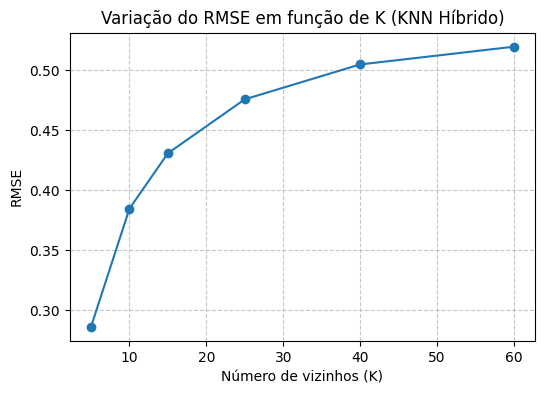

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(df_results['k'], df_results['rmse'], marker='o')
plt.title("Variação do RMSE em função de K (KNN Híbrido)")
plt.xlabel("Número de vizinhos (K)")
plt.ylabel("RMSE")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [ ]:
def recomendar_filmes(user_id, k=5, n=5):
    preds = []
    for movie_id in movie_ids:
        if pd.isna(matrix.loc[user_id, movie_id]):  # só prever filmes não vistos
            pred = predict_rating(user_id, movie_id, k)
            if not np.isnan(pred):
                preds.append((movie_id, pred))
    top = sorted(preds, key=lambda x: x[1], reverse=True)[:n]
    return pd.DataFrame(top, columns=['movieId', 'pred_rating']).merge(
        pd.read_csv("movies.csv")[['movieId', 'title', 'genres']], on='movieId')

print("\n🎬 Recomendações para o usuário 414:")
display(recomendar_filmes(414, k=5, n=5))



🎬 Recomendações para o usuário 414:


,movieId,pred_rating,title,genres
0,3030,5.100992,Yojimbo (1961),Action|Adventure
1,1203,4.875534,12 Angry Men (1957),Drama
2,1411,4.738216,Hamlet (1996),Crime|Drama|Romance
3,3083,4.719333,All About My Mother (Todo sobre mi madre) (1999),Drama
4,3451,4.715564,Guess Who's Coming to Dinner (1967),Drama
